# Ex3

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from functools import reduce
import networkx as nx

%precision 5

'%.5f'

## Task 1

In [2]:
df=pd.read_csv("bci05.csv", usecols=['sp','status','gx','gy'])  #elimino colonne inutili
df=df[df['status']=='A']    #tengo solo i vivi
df.drop('status', axis=1, inplace=True)   #elimino colonna vivi/morti

In [3]:
# counting the total number of species
number_species=df['sp'].nunique()
print('The total number of species is: ', number_species)

The total number of species is:  299


In [4]:
# renaming spiecies with their number
species = np.unique(df['sp'])
df = df.replace({'sp':dict(zip(species, np.arange(number_species)) ) }) 

In [5]:
# dividing in 800 zones and creating a dataframe for every subplot
def subplotter(n, xdim=25, ydim=25):
    
    nx=n%(1000/xdim)                  #coordinata cella orizzontale scelta (da 0 a 1000/xdim-1)
    ny=n//(1000/xdim)                 #coordinata cella verticale scelta (da 0 a 500/ydim-1)

    #print(nx, ny)
    
    return df[(xdim*nx<=df['gx']) & (df['gx'] < xdim*(nx+1) ) & 
              (ydim*ny<=df['gy']) & (df['gy'] < (ny+1)*ydim )]


In [6]:
#controllo siano tutte comprese

c=0
for i in range(800):
    c+=len(subplotter(i))
    
c==len(df)

True

In [7]:
#creo una lista contenente ciascun dataframe che rappresenta un diverso subplot
#nel quale vengono contate le volte che compare una certa specie

sub=[i for i in range(801)] #inizializzo la lista
sub[0]=pd.DataFrame(np.zeros(number_species)).rename(index=str, columns={0:'00'}) #indispenabile per mantenere tutti gli indici nel dataframe finale (joint infatti costruisce basandosi sul parametro how=left)

for i in range(800):
    # subplotter gives the species (renamed with a progressive number in the previous cells),
    # subplotter.sp.value_counts() gives the number of individuals of that species (sorted in descending order)
    # pd.DataFrame.sort_index(...) sort the content w.r.t. the index, so in our case the
    #     subplotter.sp.value_counts() is re-ordered by index, and so by species, and not
    #     basing on the frequancy of the species
    # pd.Dataframe(...).rename(...{'sp':i}) rename the column of the current DataFrame (which
    #     is called 'sp' and it is no more useful because now we want the subplot information)
    #     with the subplot number
    # all this stuff is saved at position i+1 of 'sub'
    sub[i+1]=pd.DataFrame(pd.DataFrame.sort_index((subplotter(i).sp.value_counts()))).rename(index=str, columns={'sp':i})   #conto esemplari di stess specie nel dataframe
    


In [8]:
#concateno i dataframe creati 

# reduce is a function that acts recursively on the list given
vectors=reduce(lambda x, y: pd.DataFrame.join(x,y), sub)

# Filling nan with 0s (python places "nan" to fill "void" positions when adding)
vectors.fillna(0, inplace=True)
# eliminating first column: it was used to assure that all the species were present every time we
#     added a plot in sub all species was present (python gives "nan" to fill void positions when adding)
vectors.drop('00',axis=1,inplace=True)
# renaming dataframe columns
vectors.rename_axis("species", inplace=True)
vectors.rename_axis("subplot", axis="columns", inplace=True)

# to show the matrix of subplots and their content uncomment the following line
#vectors

In [9]:
subplot_flattern = np.array(vectors.values)

In [10]:
subplot_flattern = subplot_flattern[subplot_flattern!=0] #elimino gli zeri

In [11]:
print("The flattened vector has length:", len(subplot_flattern.flatten()))
print("\nThe max in the falttened vector is:", max(subplot_flattern))

The flattened vector has length: 49479

The max in the falttened vector is: 328.0


## Task 2

In [15]:
x_interv = np.linspace(1, max(subplot_flattern), max(subplot_flattern))
prob = np.zeros(len(x_interv))
tot = np.sum(subplot_flattern)
count = np.zeros(len(x_interv))

for i in range(len(x_interv)):
    count[i] = len(subplot_flattern[subplot_flattern>x_interv[i]])

# normalizing (dividing by the first element because it has all the values: P(1) = 1 as required)
prob = count/count[0]

print("P(1) =", prob[0])

P(1) = 1.0


C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


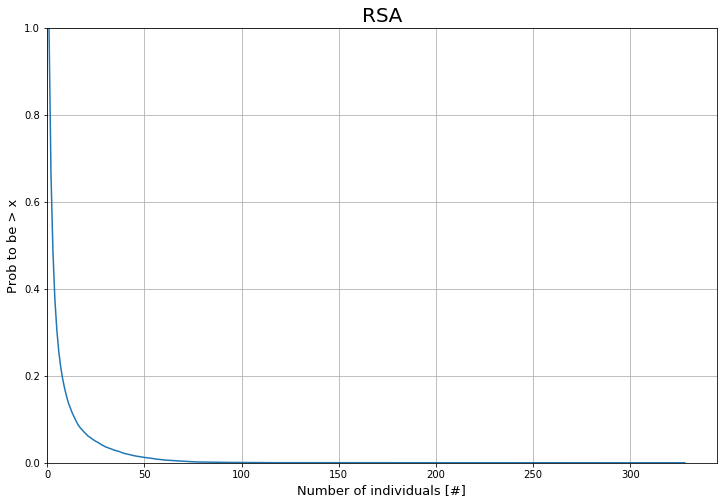

In [16]:
plt.figure(figsize=(12, 8))

plt.plot(x_interv, prob)

plt.xlim(0)
plt.ylim([0, 1])

plt.title("RSA", fontsize=20)
plt.xlabel("Number of individuals [#]", fontsize=13)
plt.ylabel("Prob to be > x", fontsize=13)

plt.grid()
plt.show()

## Task 3

Using the formula for the stationary solution:

\begin{equation}
P^*_n = -\nu \frac{ (1-\nu)^n }{ \log{(\nu)} } \frac{1}{n}
\end{equation}

where $\nu$ is the immigration rate.

In [25]:
m = 0.05        # immigration rate

x_interv_fixed = x_interv[1:]

P_station = -1*m/np.log(m) * (1-m)**x_interv_fixed / x_interv_fixed

P_station = np.append(0, P_station)
norm = np.sum(P_station)

cum_P_stat = np.cumsum(P_station/norm)

In [26]:
#modo alternativo

P_station1 = m/np.log(m) * (1-m)**x_interv_fixed / x_interv_fixed

P_station1 = np.append(0, P_station1)
norm1 = np.sum(P_station1)

cum_P_stat1 = np.cumsum(P_station1/norm1)

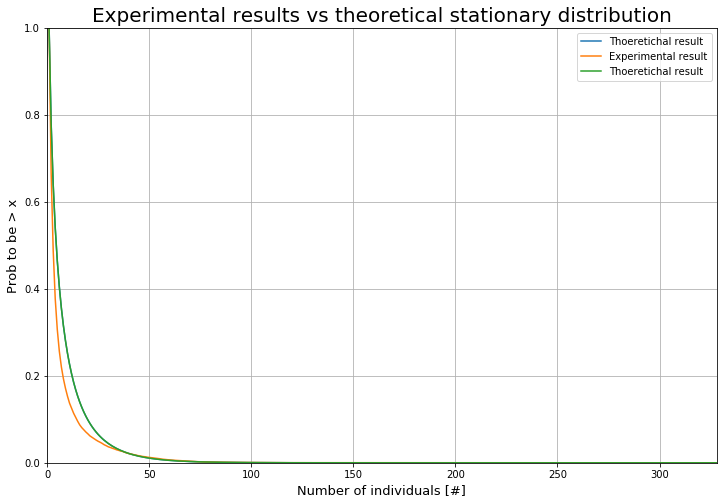

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(x_interv, 1-cum_P_stat, label="Thoeretichal result")
plt.plot(x_interv, prob, label="Experimental result")
plt.plot(x_interv, 1-cum_P_stat1, label="Thoeretichal result")


plt.ylim([0, 1])
plt.xlim([0, max(x_interv)])

plt.title("Experimental results vs theoretical stationary distribution", fontsize=20)
plt.xlabel("Number of individuals [#]", fontsize=13)
plt.ylabel("Prob to be > x", fontsize=13)
plt.legend()
plt.grid()
plt.show()

## Task 4

In [16]:
from scipy import optimize

In [17]:
#lati = np.array([1, 2, 4, 5, 10, 20, 25, 50, 100, 125, 250])
lati = np.array([4, 5, 10, 20, 25, 50, 100, 125, 250])

In [18]:
means = []
for l in lati:
    print("Doing size =", l)
    num_sub = int(1000*500/l**2)
    sub=[i for i in range(num_sub+1)] #inizializzo la lista
    for i in range(num_sub):
        sub[i+1] = len(np.unique(subplotter(i, l, l).values[:,0]))
    means.append(np.mean(sub))

Doing size = 4
Doing size = 5
Doing size = 10
Doing size = 20
Doing size = 25
Doing size = 50
Doing size = 100
Doing size = 125
Doing size = 250


In [19]:
def S_avg(ja, ν):
    num_species = 299
    A = 1000*500
    return num_species*(1 - np.log( ja/A*(1-ν)+ν ) / (np.log(ν) ) )

In [20]:
aree = lati**2
m_fit, m_fit_cov = optimize.curve_fit(S_avg, aree, means, p0=[0.05])

/home/tommaso/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [24]:
%precision 15

print(m_fit, m_fit_cov)
print(np.sqrt(m_fit_cov))

[0.000270453352612] [[1.608531928847822e-09]]
[[4.010650731300124e-05]]


In [22]:
len(np.unique(subplotter(5, 50, 50).values[:,0]))

105

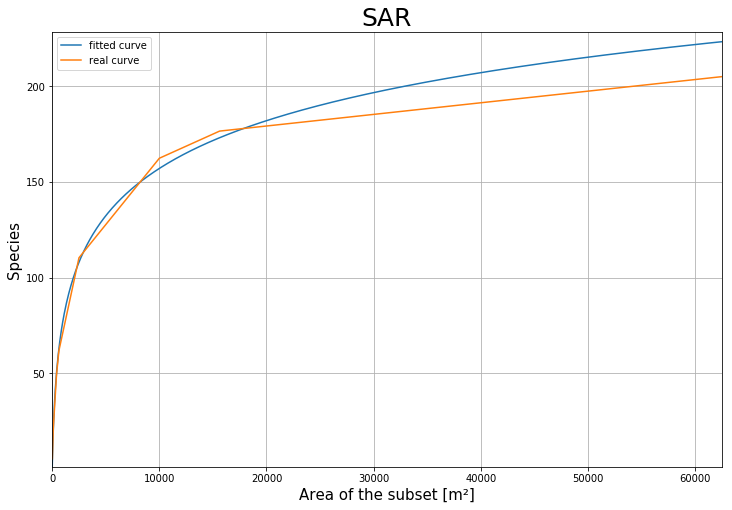

In [23]:
plt.figure(figsize=(12,8))

interv=np.linspace(4, 70000, 1000)
plt.plot(interv, S_avg(interv, m_fit), label='fitted curve')
plt.plot(aree, means, label='real curve')

plt.title("SAR", fontsize=25)
plt.xlabel("Area of the subset [m²]", fontsize=15)
plt.ylabel("Species", fontsize=15)

plt.xlim([0, max(aree)])
plt.ylim([min( S_avg(interv, m_fit)), max( S_avg(interv, m_fit))+1])


plt.legend()
plt.grid()

plt.show()

## Task 5

We have:
<ol>
    <li> Birth: A+0 $\rightarrow$ A+A with rate $b$ (per unit time and per particle); </li>
    <li> Migration: 0 $\rightarrow$ A with probability m (per unit time and per particle); </li>
    <li> Death: A $\rightarrow$ 0 with prob. d(A)=(b+m)·A/K (per unit time and per particle). </li>
</ol>

We can write:
$$ W^+ = W(A + 0 \rightarrow A+1) = b \cdot \frac{A}{K} \frac{K-A}{K-1} + m \frac{K-A}{K} \\
W^- = W(A \rightarrow A-1) = \frac{(b) \cdot A}{K} \cdot \frac{A}{K} $$

Writing the Master Equation

$$ \frac{dP_n}{dt} = P_{n+1} W^-_{n+1} + P_{n-1} W^+_{n-1} - P_n \cdot (W^+_n + W^-_n) $$

Now we define the current probability as:

$$ J(n) = P_{n}W^-_n - P_{n-1} W^+_{n-1} $$

So the Master Equation becomes:

$$ \frac{dP_n}{dt} = J(n+1) - J(n) $$

Imposing stationarity we find:

$$ 0 = J(n+1) - J(n) \quad \Rightarrow \quad J(n+1) = J(n) $$

We also have:

$$ J(0) = 0 \quad \Rightarrow \quad P_{0}W^-_0 - P_{-1} W^+_{-1} = 0 $$

Because we used the following boundaries:

$$ W^+_{-1} = 0 \quad \text{(this is not a physical situation)} \\
W^+_{0} = 0 \quad \text{(when there are 0 individuals there can not be births)} $$

we have:

$$ J(0) = 0 \quad \Rightarrow \quad J(n+1) = 0 \quad \forall n $$

It holds then:

$$ J(n+1) = P_{n+1}W^-_{n+1} - P_{n} W^+_{n} = 0 \quad \Rightarrow \quad P_{n+1} = \frac{W^+_n}{W^-_{n+1}}P_n $$

So, $\forall P_n$, it hols:

$$ P_n = \left( \prod\limits_i^n \frac{W^+_i}{W^-_{i+1}} \right) P_0 $$

Now, to find $P_0$ we have to normalize, so:

$$ \sum\limits_{n=0}^K P_n  = 1 \quad \Rightarrow \quad P_0 \sum\limits_{n=0}^K \frac{P_n}{P_0} = 1 $$

Using the fact that all fractions written above are not dependent on $P_0$, we can write:

$$ P_0 = \frac{1}{\sum\limits_{n=0}^{K} \left( \prod\limits_{i=0}^n \frac{W^+_i}{W^-_{i+1}} \right) } $$

In [112]:
W_p(1, b, K, m)*W_p(0, b, K, m)/(W_m(2, b, K, m)*W_m(1, b, K, m))/normal

0.008539778709429534

We have:
<ol>
    <li> Birth: A+0 $\rightarrow$ A+A with rate $b$ (per unit time and per particle); </li>
    <li> Migration: 0 $\rightarrow$ A with probability m (per unit time and per particle); </li>
    <li> Death: A $\rightarrow$ 0 with prob. d(A)=(b+m)·A/K (per unit time and per particle). </li>
</ol>

We can write:
$$ W^+ = W(A \rightarrow A+1) = b \cdot A + m \\
W^- = W(A \rightarrow A-1) = \frac{b \cdot A}{K} \cdot A $$

Writing the Master Equation

$$ \frac{dP_n}{dt} = P_{n+1} W^-_{n+1} + P_{n-1} W^+_{n-1} - P_n \cdot (W^+_n + W^-_n) $$

Now we define the current probability as:

$$ J(n) = P_{n}W^-_n - P_{n-1} W^+_{n-1} $$

So the Master Equation becomes:

$$ \frac{dP_n}{dt} = J(n+1) - J(n) $$

Imposing stationarity we find:

$$ 0 = J(n+1) - J(n) \quad \Rightarrow \quad J(n+1) = J(n) $$

We also have:

$$ J(0) = 0 \quad \Rightarrow \quad P_{0}W^-_0 - P_{-1} W^+_{-1} = 0 $$

Because we used the following boundaries:

$$ W^+_{-1} = 0 \quad \text{(this is not a physical situation)} \\
W^+_{0} = 0 \quad \text{(when there are 0 individuals there can not be births)} $$

we have:

$$ J(0) = 0 \quad \Rightarrow \quad J(n+1) = 0 \quad \forall n $$

It holds then:

$$ J(n+1) = P_{n+1}W^-_{n+1} - P_{n} W^+_{n} \quad \Rightarrow \quad P_{n+1} = \frac{W^+_n}{W^-_{n+1}}P_n $$

So, $\forall P_n$, it hols:

$$ P_n = \left( \prod\limits_i^n \frac{W^+_i}{W^-_{i+1}} \right) P_0 $$

Now, to find $P_0$ we have to normalize, so:

$$ \sum\limits_{n=0}^K P_n  = 1 \quad \Rightarrow \quad P_0 \sum\limits_{n=0}^K \frac{P_n}{P_0} = 1 $$

Using the fact that all fractions written above are not dependent on $P_0$, we can write:

$$ P_0 = \frac{1}{\sum\limits_{n=0}^{K} \left( \prod\limits_{i=0}^n \frac{W^+_i}{W^-_{i+1}} \right) } $$

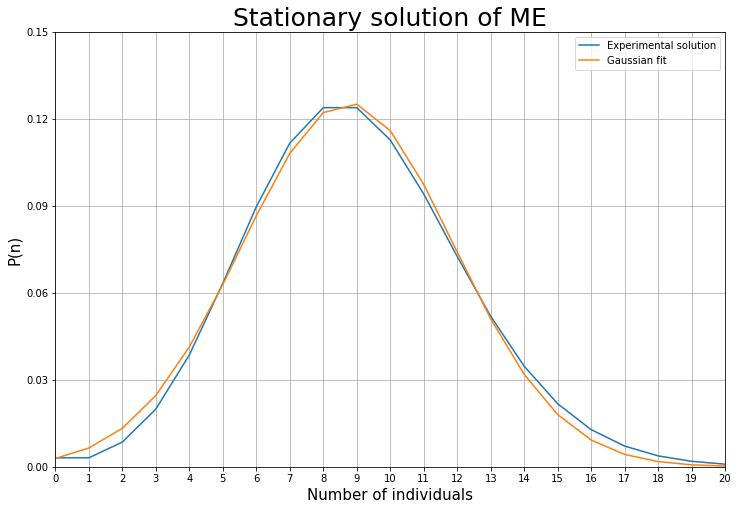

In [25]:
def norm(x, mu, sigma):
    return 1/np.sqrt(2*sigma**2*np.pi)  *  np.exp(-(x-mu)**2/(2*sigma**2))

def W_p(n, b = 1, K = 10, m = 0):
    return b*n + m

def W_m(n, b = 1, K = 10, m = 0):
    return b*n/K*n

K = 10
m = 0.1
b = 1

population = np.arange(2*K+1)

prob_pop = np.zeros(2*K+1)
prob_pop[0] = 1

for i in range(1, len(population)):
    temp = 1
    for j in range(i):
        temp *= W_p(j, b, K, m)/W_m(j+1, b, K, m)
    prob_pop[i] = temp

normal = np.sum(prob_pop)

prob_pop /= normal


res, cov = optimize.curve_fit(norm, population, prob_pop, p0=[9, 1])


plt.figure(figsize=(12,8))
plt.plot(population, prob_pop, label='Experimental solution')
plt.plot(population, norm(population, res[0], res[1]), label='Gaussian fit')

plt.title("Stationary solution of ME", fontsize=25)
plt.xlabel("Number of individuals", fontsize=15)
plt.ylabel("P(n)", fontsize=15)

plt.xticks(np.linspace(0, 2*K, 2*K+1))
plt.yticks(np.linspace(0, 0.15, 6), label = np.round(np.linspace(0, 0.15, 6), decimals = 2))

plt.xlim([0, 2*K])
plt.ylim([0, 0.15])


plt.grid()

plt.legend()
plt.show()

In [26]:
avg_pop = np.sum(prob_pop*population)
std_pop = np.sqrt(np.sum(prob_pop*(population-avg_pop)**2))

print("The average population is:", avg_pop)
print("The std is:", std_pop)

print("\n",res)
print(cov, end="\n\n")


print("\nPrinting some stuff to be properly reported in the pdf file:\n")
print(res[0], "±", np.sqrt(cov[0][0]))
print(res[1], "±", np.sqrt(cov[1][1]))

The average population is: 8.945351944749246
The std is: 3.2019797049736756

 [8.736627517466575 3.178950319464543]
[[ 1.966349703493009e-03 -1.210890021044145e-06]
 [-1.210890021044145e-06  1.312766489579730e-03]]


Printing some stuff to be properly reported in the pdf file:

8.736627517466575 ± 0.04434354184650803
3.1789503194645428 ± 0.03623211958442025


In [29]:
# trying Kullback-Leibler
D = np.sum(prob_pop*np.log2(prob_pop/norm(population, res[0], res[1])))
print("The Kullback-Leibler P|Q: ", D)

# trying "Kullback-Leibler inverting distributions
D1 = np.sum( norm(population, res[0], res[1]) *np.log2(norm(population, res[0], res[1])/prob_pop))
print("The Kullback-Leibler Q|P: ", D1)

The Kullback-Leibler P|Q:  0.012650414260878111
The Kullback-Leibler Q|P:  0.006837993218414257
